In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis of Tweet Location by Time

I hypothesize that the time at which a tweet is sent will be a significant factor in teasing out the location of the sender. If it's 7:00 am on a Tuesday in London, who is more likely to be tweeting: a Brit or an American? 

| Time Zone | Time    | Location |
|--- |----------| ------|
| PDT | midnight  | Los Angeles |
| MDT | 1:00 am | Denver |
| CDT | 2:00 am | Chicago |
| EDT | 3:00 am| New York City |
| BST | 7:00 am| London|


While Angelenos may still be up at midnight and tweeting, it seems unlikely that the average New Yorker will be tweeting at 3 in the morning. At 7 am, however, the average Londoner is awake and moving into their day. If my only data point were the time of day, I would predict that at 7:00 UTC -- Coordinated Universal Time, the time zone Twitter uses -- the tweeter would more likely come from the UK than from the US.

From my database of 10.7 million tweets about coronavirus, I queried self-reported locations of: UK, USA, England, Scotland, London, Liverpool, Edinburgh, New York, Texas, California, New York City, Chicago, Los Angeles, Houston, Dallas, Austin, Denver, and Atlanta. This is by no means a complete or even (necessarily) representative sample of the total number of tweets from the United States and the United Kingdom, but it was enough to allow some exploratory data analysis of the relationship of location to time. The initial dataset from this query contained 319,127 tweets. It ranged from March 19-24, 2020, after Daylight Savings Time started in the US but before British Summer Time began in the UK.

In [171]:
# The file name says 200K, but there were more than 300,000 rows.
file = '../200K_US_UK.csv'
df = pd.read_csv(file, error_bad_lines=False)

### Taking a first look
There's something weird going on with the `place` column. It has only 1,991 non-null entries and only 91 unique entries.

In [172]:
df.count()

pk                 319127
username           318669
created_at         315696
tweet              318209
location           312574
place                1991
followers_count    311817
dtype: int64

In [173]:
df.nunique()

pk                 316775
username            92640
created_at         170745
tweet              150976
location              704
place                  91
followers_count     25700
dtype: int64

In [427]:
df.date.max()

Timestamp('2020-03-24 02:21:10')

I have no idea what's going on with `place`. It looks like spillover from another column perhaps. 

In [176]:
df.place.sort_values().head(10)

312539                         INCINERATED!!!
312549                         INCINERATED!!!
312551                         INCINERATED!!!
312864                         INCINERATED!!!
271342                                  May 2
56872                                   TEST"
117096                                  TEST"
116151                                   TLB 
176754              according to the source."
88850      and alleviates challenges we have"
Name: place, dtype: object

In [177]:
# Time to drop it
df = df.drop(columns='place')

In [178]:
df.head(2)

,pk,username,created_at,tweet,location,followers_count
0,10571759,nytimes,Tue Mar 24 00:42:34 +0000 2020,If it were possible to wave a magic wand and m...,New York City,45746727
1,10005992,nytimes,Mon Mar 23 21:20:02 +0000 2020,Joe Biden on Monday criticized President Trump...,New York City,45743620


### Dropping nulls
These tweets are only useful for this analysis if they contain both the date/time they were created and the location from which they were tweeted. Any rows with null values in one or both of these columns can be dropped.

In [179]:
df = df.dropna(subset=['created_at', 'location'])

In [181]:
# It looks like the only null values left are in the followers_count, but those nulls
# should have no effect on my hypothesis, so I'm leaving them in
df.count()

pk                 312574
username           312574
created_at         312574
tweet              312144
location           312574
followers_count    311817
dtype: int64

In [185]:
# Every data type is an object. I want `created_at` to be a datetime object.
df.dtypes

pk                 object
username           object
created_at         object
tweet              object
location           object
followers_count    object
dtype: object

### Working with time values
When I initially ran the `pd.to_datetime` function for the `created_at` column, it errored out. I sorted the dataframe to see what was going on. It turns out that there are some weird values in some places. It looks like things may have gotten shifted incorrectly for a few rows in the original data pull from Twitter or in the query from MySQL. I re-ran the function to coerce errors into null values that I could drop and to format the expected values into the correct datetime object.

In [183]:
df.sort_values('created_at').head()

,pk,username,created_at,tweet,location,followers_count
58926,There is a reason for why China,South Korea,Japan,"Singapore &amp; Taiwan…""",USA,4611
263001,There is a reason for why China,South Korea,Japan,"Singapore &amp; Taiwan…""",USA,148
293315,- @jhalamka,President,Mayo Clinic Platform,"and…""",USA,61
72761,Italy,Spain,and France have tested a total of at LEAST 100,"… https://t.co/5h3JLh6kn5""",California,3638
96436,Waffle,waffle,bluster,"bl…""",UK,2412


In [189]:
df['date'] = pd.to_datetime(df.created_at, 
                            errors='coerce',
                            format='%a %b %d %H:%M:%S +0000 %Y')

In [190]:
# Just a few NaN values in date
df.isna().sum()

pk                 0
username           0
created_at         0
tweet              0
location           0
followers_count    0
date               6
dtype: int64

In [191]:
# I've dropped all of the null values
df = df.dropna()

In [193]:
# And now date is a correctly formatted object that I can work with.
df.dtypes

pk                         object
username                   object
created_at                 object
tweet                      object
location                   object
followers_count            object
date               datetime64[ns]
dtype: object

### Date breakdown
Now I'd like a couple of new columns: one for the hour of the day and one for the day of the week. I can use an attribute of the datetime object to get the former and a method to get the latter.

In [234]:
df['hour'] = df.date.apply(lambda x: x.hour)

In [227]:
df['day'] = df.date.apply(lambda x: x.day_name())

In [235]:
# Looks pretty good to me
df.head()

,pk,username,created_at,tweet,location,followers_count,date,day,hour
0,10571759,nytimes,Tue Mar 24 00:42:34 +0000 2020,If it were possible to wave a magic wand and m...,New York City,45746727,2020-03-24 00:42:34,Tuesday,0
1,10005992,nytimes,Mon Mar 23 21:20:02 +0000 2020,Joe Biden on Monday criticized President Trump...,New York City,45743620,2020-03-23 21:20:02,Monday,21
2,9875083,nytimes,Mon Mar 23 20:14:06 +0000 2020,RT @zwoolfe: BREAKING: The New York Philharmon...,New York City,45742242,2020-03-23 20:14:06,Monday,20
3,9857476,nytimes,Mon Mar 23 20:07:47 +0000 2020,Breaking News: Stocks on Wall Street dropped a...,New York City,45742108,2020-03-23 20:07:47,Monday,20
4,9641520,nytimes,Mon Mar 23 18:50:02 +0000 2020,RT @emmabgo: What does it look like to be a me...,New York City,45740677,2020-03-23 18:50:02,Monday,18


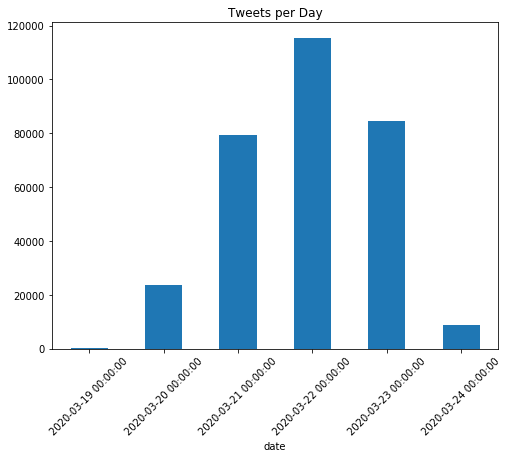

In [403]:
# Quick plot shows that most of my dataset's tweets come from March 22, 2020
days.size().plot(kind='bar', rot=45, title='Tweets per Day', figsize=(8,6))

In [232]:
# The total length of the dataset is a little over four days
df.date.max() - df.date.min()

Timedelta('4 days 05:49:38')

### Getting Clean Location Data
This is the second critical part of my exploratory data analysis. I limited my query to those who only listed the USA or UK as their location or one of a few major cities and states. I ended up with 115 unique values, many of which are variant spellings of the same place, and a few of which aren't a place at all, like `' sailors'`. 

In [240]:
df.location.unique()

array(['New York City', 'London', 'Los Angeles', 'England', 'New York',
       'NYC', 'USA', 'LONDON', 'California', 'UK', 'United Kingdom',
       'Atlanta', 'Boston', 'Liverpool', 'Texas', 'nyc', 'new york',
       'los angeles', 'NEW YORK CITY', 'Ohio', 'chicago', 'Chicago',
       'london', 'Nyc', ' sailors', 'Glasgow', 'england', 'Houston',
       'usa', 'Dallas', 'uk', 'texas', 'ATLANTA', 'Austin', 'LOS ANGELES',
       'Los angeles', 'austin', 'liverpool', 'TEXAS', 'new york city',
       'atlanta', 'california', 'NEW YORK', 'HOUSTON', 'ohio', 'Usa',
       'CALIFORNIA', 'glasgow', 'houston', 'Uk', 'BOSTON', 'CHICAGO',
       'GLASGOW', 'boston', 'OHIO', 'New York CIty', 'New york',
       'Los Ángeles', 'CHICAGØ', 'united kingdom', 'oHIo', 'USa',
       'New York city', 'dallas', 'nYc', 'United kingdom', 'ⓊⓀ',
       ' we did this', 'ENGLAND', 'LIVERPOOL', 'californiA',
       'ˡᵒˢ ᵃⁿᵍᵉˡᵉˢ', 'DALLAS', 'uSA', 'UNITED KINGDOM', 'OHio', 'UsA',
       'new York city', 'teXas', 'nÿc

I created a lookup table in Python for each of these listed locations to map to a standardized location. Countries listed by themselves were mapped either to `USA` or `UK`. Cities or states were mapped as follows:

    'London': 'England, UK',
    'Austin': 'TX, USA',
    ' folks."': None
    
I then imported the table so that I could create a new column called `state` to contain this standardized location. 

In [247]:
from locations import loc_names

In [249]:
# Quick test
loc_names['TeXaS']

'TX, USA'

In [250]:
# Creating a `state` column
df['state'] = df.location.apply(lambda x: loc_names[x])

In [254]:
# Unique locations include None type because I mapped non-location values to None
df.state.unique()

array(['NY, USA', 'England, UK', 'CA, USA', 'UK', 'USA', 'GA, USA',
       'MA, USA', 'TX, USA', 'OH, USA', 'IL, USA', None, 'Scotland, UK'],
      dtype=object)

In [256]:
# Which allows me to drop them.
df = df.dropna()

In [257]:
# Now we can see that 11 unique locations are included.
df.state.unique()

array(['NY, USA', 'England, UK', 'CA, USA', 'UK', 'USA', 'GA, USA',
       'MA, USA', 'TX, USA', 'OH, USA', 'IL, USA', 'Scotland, UK'],
      dtype=object)

In [258]:
# The dataframe should stay about this size from here forward
len(df)

311801

### Making a Country Column
I want to be able to do a binary either/or for the United States and the United Kingdom. To create the `country` column, I made a custom function that quickly outputs whether the corresponding value in the `state` column contains `USA` or `UK`.

In [259]:
def country(location):
    """
    Returns either UK or USA
    """
    if 'USA' in location:
        return 'USA'
    else:
        return 'UK'

In [406]:
df['country'] = df.state.apply(country)

### How does the data split out? 
Roughly 64% of these 311,000 tweets originate in the US and the remainder in the UK.

In [262]:
df.groupby('country').sum()

,hour
country,
UK,1464263
USA,2508529


In [274]:
# 34% of these tweets originate in the UK

len(df[df.country=='UK'])/len(df)

0.34311307532689117

### A quick look at content
For future exploration, I'll be looking to see if retweets are a factor in determining location. I wanted to get a sense of their distribution in this dataset.

In [282]:
# Slightly fewer than half of the tweets are unique
df.tweet.nunique()/len(df)

0.47377012902460225

In [285]:
# Yikes -- about 78% of all these tweets are actually retweets
df.tweet.str.startswith('RT').sum()/len(df)

0.7781950667252511

In [410]:
# About 74% of British tweets are retweets
df[df.country=='UK'].tweet.str.startswith('RT').sum()/len(df[df.country=='UK'])

0.7389959152388698

In [411]:
# About 80% of American tweets are retweets
df[df.country=='USA'].tweet.str.startswith('RT').sum()/len(df[df.country=='USA'])

0.7986700387661241

In [445]:
df[df.country=='USA'].tweet.str.startswith('RT').unique().sum()

1

In [451]:
# Unique tweets that are not re-tweets count for only 68,798 of the 311,000 tweets
df.tweet.drop_duplicates().count() - df.tweet.drop_duplicates().str.startswith('RT').sum()

68798

In [452]:
# Proportion of all tweets that are unique and not re-tweets
68798/len(df)

0.22064714353064935

## Graphic Analysis
I'll start off with grouping the data by hour and by country. Unfortunately, this graph is hard to read and doesn't make it clear which country leads each hour in tweeting.

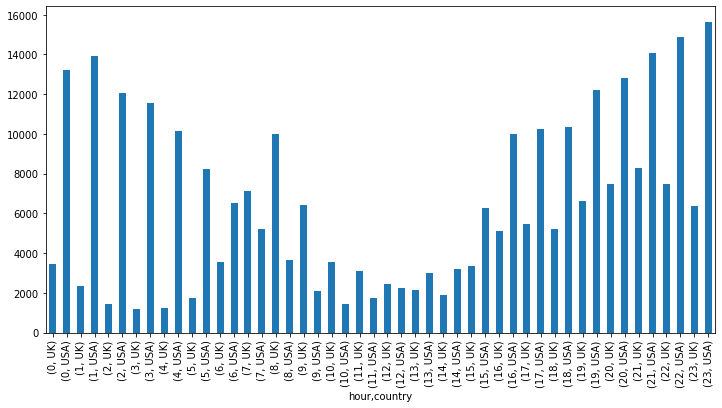

In [327]:
df.groupby(['hour', 'country']).size().plot(kind='bar', figsize=(12,6))

A visual of the groupby numbers isn't that much more helpful.

In [443]:
df.groupby(['hour', 'country'])['tweet'].count().head(10)

hour  country
0     UK          3434
      USA        13222
1     UK          2334
      USA        13944
2     UK          1441
      USA        12056
3     UK          1207
      USA        11580
4     UK          1249
      USA        10145
Name: tweet, dtype: int64

### Total Tweets per Hour
Looking at total tweets per hour, we see a dip from 10 am to 2 pm UTC. Here's what that time frame looks like for this dataset.

| Time    | Location |
|----------| ------|
| 3:00 am -  7 am| Los Angeles |
| 4:00 am - 8 am| Denver |
| 5:00 am - 9 am| Chicago |
| 6:00 am - 10 am| New York City |
| 10:00 am - 2 pm| London|

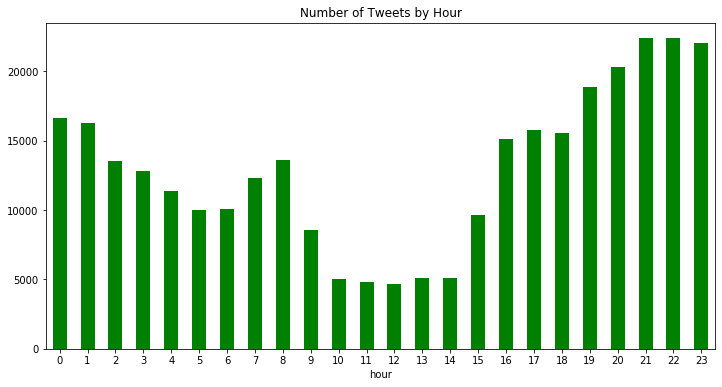

In [332]:
df.groupby('hour')['tweet'].count().plot(kind='bar', 
                                         rot=0,
                                        title='Number of Tweets by Hour',
                                        figsize=(12,6),
                                        color='green')

### Scaling Tweet Location
For a better look at the distribution of tweets over different hours, it's important to understand the proportion of tweets by location. If tweets from the UK were equal in number to tweets from the US, then a graph of the two would clearly show which hour contains a greater proportion of tweets from each country. 

Below is a look at the number of tweets per hour by country over this dataset.

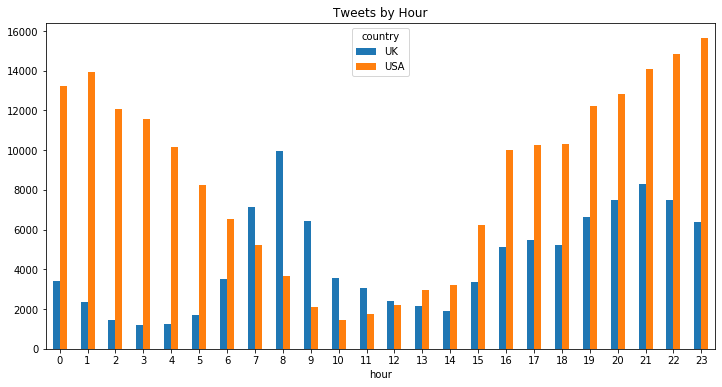

In [429]:
pd.crosstab(df.hour, df.country).plot(kind='bar', 
                                      figsize=(12,6),
                                     title='Tweets by Hour',
                                     rot=0)

### How do we balance the data?

It seems pretty obvious that the UK out-tweets the US from 7 am to noon GMT. What about at 1 or 2 pm, when the two are close in number? If each country is contributing half of all tweets, then clearly the US is tweeting more. But it turns out that it's not a 50-50 split in the data.

In [358]:
print('Proportion of all tweets that are from the UK:', len(df[df.country=='UK'])/len(df))
print('Proportion of all tweets that are from the USA:', len(df[df.country=='USA'])/len(df))

Proportion of all tweets that are from the UK: 0.34311307532689117
Proportion of all tweets that are from the USA: 0.6568869246731088


### Normalizing by Index
The United States is running at a nearly 2:1 margin. Let's try normalizing the data to tell who is really tweeting more. We'll make a cross-tabulation of hour by country for total tweet count and then normalize it.

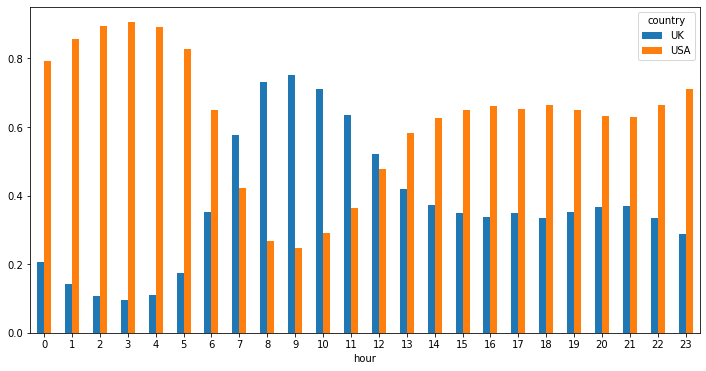

In [382]:
pd.crosstab(df.hour, df.country, normalize='index').plot(kind='bar', figsize=(12,6), rot=0)

This graph looks a little strange, even if it has a retro 1970's design coolness. 

Normalization is extremely useful in statistics. It allows you to use proportions to scale data and make meaningful comparisons. 

The Pandas `crosstab` function is extremely useful for normalizing data. It takes categorical data and tabulates (counts) it for you. For this graph series, I tabulated the `hour` and `country` columns of the dataframe. The output is a count of total tweets per country for each of the 24 hours in a day. 

Here's the head of the crosstab:

In [379]:
tab = pd.crosstab(df.hour, df.country)
tab.head()

country,UK,USA
hour,,
0,3434,13222
1,2334,13944
2,1441,12056
3,1207,11580
4,1249,10145


For each hour (row) you can see the corresponding number of tweets per country (column).

In the graph above, we normalized for index. That means that each row was normalized; each row's cells are made into proportions that sum to one. This is done by dividing a cell by the sum of its row to get the proportion of the row's total that each cell contains. From the cross-tabulation above, we can find that the UK has 20% of the hour 0's tweets and the USA has the other 80%.

$$ \frac{3434}{(3434 + 13222)} = 0.20 \,\,  and \,\,\frac{13222}{(3434 + 13222)}= 0.80$$

Below you can see the same cross-tabulation normalized for row (index).

In [433]:
pd.crosstab(df.hour, df.country, normalize='index').head()

country,UK,USA
hour,,
0,0.206172,0.793828
1,0.143384,0.856616
2,0.106764,0.893236
3,0.094393,0.905607
4,0.109619,0.890381


### Normalizing for the Entire Dataset
Another option when normalizing is to see what proportion a single value is of the total count in a dataset. I set `margins=True`, which allows you to see the totaled amounts by row and column in the cross-tabulation in the cell below. At the bottom right is the total number of tweets in this dataset: 311,801. Each cell contains the number of tweets for the UK or USA in a particular hour. If we normalize for the entire dataset, then every cell in the entire table value will be split into proportions that all together will sum to one.

Example from hour 20:

$$ \frac{7473}{311801} = 0.0239 \,\,  and \,\,\frac{12832}{311801}= 0.0397 $$

We see that 2.39% of all tweets across the whole dataset come from the UK at 8 pm UTC, and that 3.97% of all tweets from the whole dataset come from the US at the same time.

In [401]:
pd.crosstab(df.hour, df.country, margins=True).tail()

country,UK,USA,All
hour,,,
20,7473,12832,20305
21,8292,14089,22381
22,7494,14868,22362
23,6362,15640,22002
All,106983,204818,311801


In [432]:
# The data normalized over the entire dataset
pd.crosstab(df.hour, df.country, normalize=True).tail()

country,UK,USA
hour,,
19,0.021244,0.039217
20,0.023967,0.041154
21,0.026594,0.045186
22,0.024035,0.047684
23,0.020404,0.050160


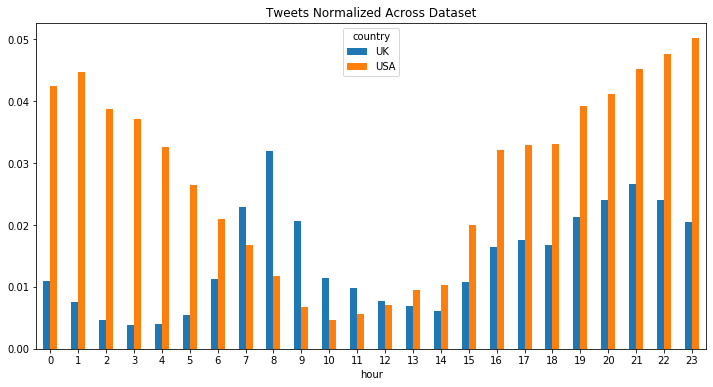

In [431]:
pd.crosstab(df.hour, df.country, normalize=True).plot(kind='bar', 
                                                      figsize=(12,6),
                                                     rot=0,
                                                     title='Tweets Normalized Across Dataset')

This looks a bit different from the first graph, but it's not really getting at what I'm trying to find out. What I'd like to know is what proportion of a given country's tweets are coming at any particular hour.

### Normalizing by Column

This last way of normalizing using `pd.crosstab` is to take each column's cells as a proportion of the column's total. For every hour, you'll see the proportion of a country's total tweets that were tweeted at that hour. Here's the cross-tabulation: 

In [435]:
pd.crosstab(df.hour, df.country, normalize='columns').head()

country,UK,USA
hour,,
0,0.032099,0.064555
1,0.021817,0.068080
2,0.013469,0.058862
3,0.011282,0.056538
4,0.011675,0.049532


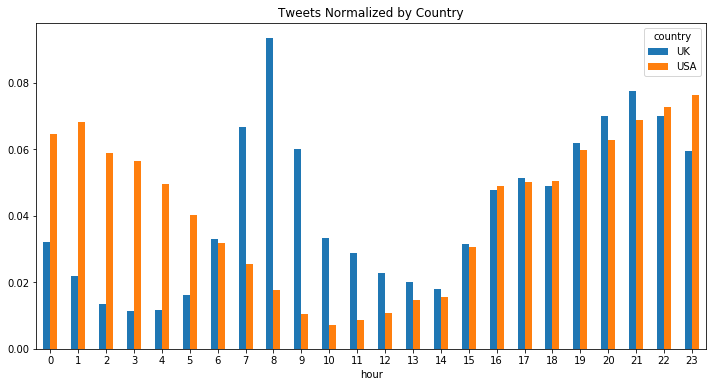

In [439]:
pd.crosstab(df.hour, df.country, normalize='columns').plot(kind='bar', 
                                                           figsize=(12,6),
                                                          title='Tweets Normalized by Country',
                                                          rot=0)

### This is suddenly much more informative.
Right away we can see that at 8 am, the UK has an enormous peak of tweeting, one that is much higher than any American peak. Moreover, we can see that a second peak appears at 9 pm. This is interesting because it's a different pattern than the American one, which has a single peak at 11 pm UTC. 

More interesting still, British and American tweeting proportions stay nearly even with each other in proportion from 2 pm to 11 pm UTC. Looking at this graph, there's a very clear divide between countries in tweet count before noon. After 1 pm, however, it's difficult to differentiate which country is tweeting more. If time were the only predicting factor, we could throw out any data from 13:00 to 23:00 UTC as useless for predicting which country the tweeter hails from. From midnight through noon UTC, however, it looks like a pretty good predictor.

One other interesting visualization is the heatmap below. Darker colors correspond to a higher proportion of tweets. You can see how the bands for the early hours differ between countries and start to look similar after noon. It's also very apparent at what the time the peak in the UK is and how much larger (darker) it is than any other band in the graph.

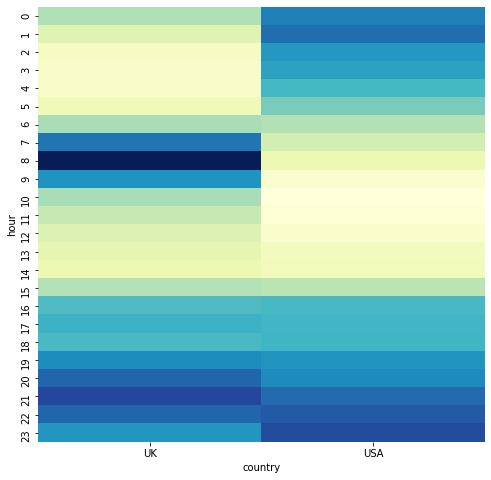

In [441]:
plt.figure(figsize=(8,8))
sns.heatmap(pd.crosstab(df.hour, df.country, normalize='columns'),
            cmap="YlGnBu", cbar=False)

The graphs above were helpful for teasing out some interesting information about the data and setting a direction for further exploration. I may see if language in the tweets from midnight to noon correlates at all with time and then test tweets from later hours to see if they follow the same pattern. There are a lot of directions to take with modeling this data.

### Scaling for Data Pre-processing

The next step is getting the data scaled properly for machine learning. The UK data, with its two peaks, doesn't follow a normal distribution, and so some data transformation will be required. I may be able to skip this step (or make it more accurate) by discarding data from the right half of the graph for training purposes. My plan is to try modeling it both ways and see which is more accurate.

The standard for scaling is to use Sci-kit Learn's preprocessing module. I'll do that and then take a look at the graph to see if there's any new interesting information that can be gleaned.

In [364]:
from sklearn import preprocessing

In [365]:
min_max_scaler = preprocessing.MinMaxScaler()

In [366]:
x_scaled = min_max_scaler.fit_transform(tab)

In [370]:
normalized = pd.DataFrame(x_scaled, columns=['UK', 'USA'])

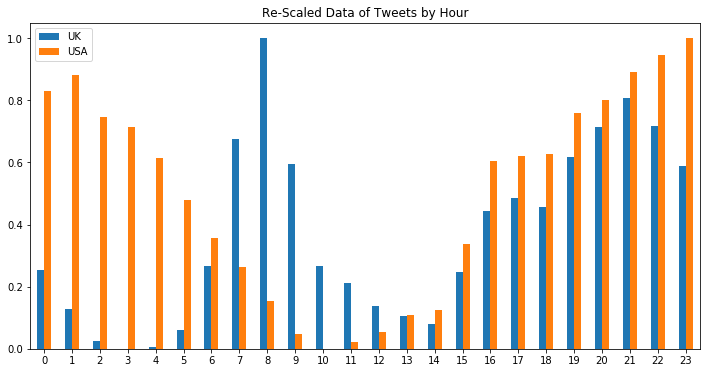

In [387]:
normalized.plot(kind='bar', figsize=(12,6), title='Re-Scaled Data of Tweets by Hour', rot=0)

### A last look at the re-scaled dataset
Looking at the heatmap of the pre-processed dataset shows something interesting: the data from the two countries is clearly differentiated after 1 pm. This suggests that it won't just be noise in the training process.

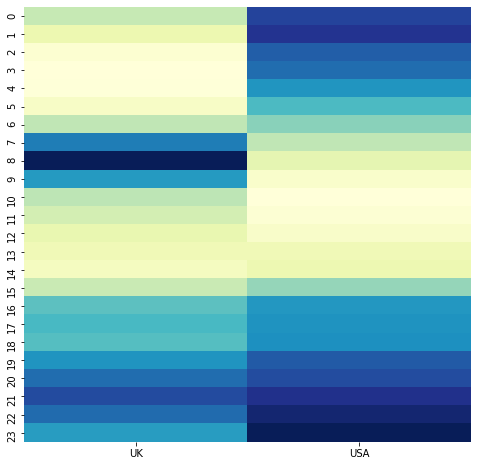

In [444]:
plt.figure(figsize=(8,8))
sns.heatmap(normalized,
            cmap="YlGnBu", cbar=False)